In [11]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
import torch.optim as optim
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
import json
import cv2

# 모델 및 데이터셋 클래스 임포트
from models import Net
from custom_transforms import Rescale, Normalize, ToTensor
from facial_keypoints_dataset import CatKeypointsDataset


In [12]:
import torch.multiprocessing as mp
mp.set_start_method('fork', force=True)


In [13]:
%load_ext autoreload
%autoreload 2

import torch

device = "cpu"
print("Using device:", device)

# 데이터 경로 설정
labels_dir = '/home/work/XAI/BITAmin/CatFLW/labels'
images_dir = '/home/work/XAI/BITAmin/CatFLW/images'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cpu


In [14]:
# 데이터 변환 정의
data_transform = transforms.Compose([
    Rescale((224, 224)),  # 크기를 224x224로 조정
    Normalize(color=True),  # RGB로 유지
    ToTensor()
])
# 데이터셋 및 데이터로더 생성
train_dataset = CatKeypointsDataset(labels_dir=labels_dir, images_dir=images_dir, transform=data_transform)
test_dataset = CatKeypointsDataset(labels_dir=labels_dir, images_dir=images_dir, transform=data_transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)


In [15]:

# 얼굴 검출기를 초기화합니다.
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalcatface.xml')

# 얼굴을 검출하고 얼굴 영역만 추출하는 함수
def extract_face(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    if len(faces) > 0:
        (x, y, w, h) = faces[0]  # 첫 번째 얼굴만 사용합니다.
        face = image[y:y+h, x:x+w]
        return face, (x, y, w, h)
    else:
        return None, None

In [16]:
# 키포인트 예측을 위한 함수
def detect_keypoints_on_face(face_image, model):
    face_image = cv2.resize(face_image, (224, 224))
    face_image = face_image / 255.0  # 정규화
    face_image = np.transpose(face_image, (2, 0, 1))  # 채널 순서 변경
    face_tensor = torch.from_numpy(face_image).unsqueeze(0).type(torch.FloatTensor).to(device)

    with torch.no_grad():
        model.eval()
        output_pts = model(face_tensor).view(48, 2).cpu().numpy()
        output_pts = output_pts * 50.0 + 100  # 반정규화
    return output_pts

# 원본 이미지에 키포인트를 다시 매핑하는 함수
def map_keypoints_to_original_image(keypoints, face_coords, original_image_shape):
    x, y, w, h = face_coords
    keypoints[:, 0] = keypoints[:, 0] * (w / 224.0) + x
    keypoints[:, 1] = keypoints[:, 1] * (h / 224.0) + y
    return keypoints

# 전체 파이프라인을 통합하는 함수
def process_image_and_detect_keypoints(image, model):
    face, face_coords = extract_face(image)
    if face is not None:
        keypoints = detect_keypoints_on_face(face, model)
        mapped_keypoints = map_keypoints_to_original_image(keypoints, face_coords, image.shape)
        return mapped_keypoints
    else:
        return None

# 네트워크 샘플 출력 함수
def net_sample_output(model, test_loader):
    for i, sample in enumerate(test_loader):
        images = sample["image"].to(device)
        key_pts = sample["keypoints"].to(device)

        images = images.type(torch.FloatTensor).to(device)
        output_pts = model(images)
        output_pts = output_pts.view(output_pts.size()[0], 48, 2)  # [batch_size, 48, 2]

        if i == 0:
            return images, output_pts, key_pts


In [17]:
# 모델 인스턴스화 및 출력
net = Net().to(device)
print(net)


Net(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.3, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [18]:
# 훈련 함수 정의
def train_net(n_epochs):
    losses = []
    net.train()
    for epoch in tqdm_notebook(range(n_epochs), desc="training"):
        running_loss = 0.0
        for data in tqdm_notebook(train_loader, desc="epoch {}".format(epoch)):
            images = data["image"].to(device)
            key_pts = data["keypoints"].to(device)
            key_pts = key_pts.view(key_pts.size(0), -1)
            key_pts = key_pts.type(torch.FloatTensor).to(device)
            images = images.type(torch.FloatTensor).to(device)
            output_pts = net(images)
            loss = criterion(output_pts, key_pts)
            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch: {epoch + 1}, Avg. Loss: {running_loss / len(train_loader)}")
    return losses
    print("Finished Training")

In [19]:
# 손실 함수 및 옵티마이저 설정
criterion = nn.SmoothL1Loss().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)


training:   0%|          | 0/14 [00:00<?, ?it/s]

epoch 0:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch: 1, Avg. Loss: 0.6964507572578661


epoch 1:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch: 2, Avg. Loss: 0.4152382323236177


epoch 2:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch: 3, Avg. Loss: 0.3449063644264684


epoch 3:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch: 4, Avg. Loss: 0.31421811246510706


epoch 4:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch: 5, Avg. Loss: 0.2744693900599624


epoch 5:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch: 6, Avg. Loss: 0.24404011170069376


epoch 6:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch: 7, Avg. Loss: 0.21640441950523492


epoch 7:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch: 8, Avg. Loss: 0.1997531598264521


epoch 8:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch: 9, Avg. Loss: 0.181701736016707


epoch 9:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch: 10, Avg. Loss: 0.17800747129050168


epoch 10:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch: 11, Avg. Loss: 0.1641083224253221


epoch 11:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch: 12, Avg. Loss: 0.15515072305094113


epoch 12:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch: 13, Avg. Loss: 0.14912284368818457


epoch 13:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch: 14, Avg. Loss: 0.13626093349673532


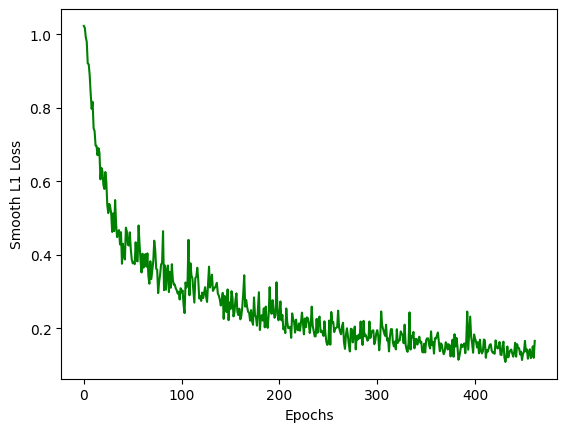

In [20]:
# 네트워크 훈련
n_epochs = 14
losses = train_net(n_epochs)
plt.xlabel("Epochs")
plt.ylabel("Smooth L1 Loss")
plt.plot(losses, "g-")


In [21]:
import os

# 모델 저장
model_dir = "models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model_name = "cat_keypoints_model3.pt"
model_path = os.path.join(model_dir, model_name)
torch.save(net.state_dict(), model_path)


In [22]:
# 테스트 데이터 다시 가져오기
test_images, test_outputs, gt_pts = net_sample_output(net, test_loader)
print(test_images.size())
print(test_outputs.size())
print(gt_pts.size())


torch.Size([64, 3, 224, 224])
torch.Size([64, 48, 2])
torch.Size([64, 48, 2])


In [23]:
# 키포인트 시각화 함수
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    plt.imshow(image, cmap="gray")
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker=".", c="m")
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker=".", c="g")


In [24]:
# 시각화 함수
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    plt.figure(figsize=(20, 10))
    for i in range(batch_size):
        ax = plt.subplot(batch_size // 5, 5, i + 1)
        image = test_images[i].cpu().data.numpy()
        image = np.transpose(image, (1, 2, 0))
        predicted_key_pts = test_outputs[i].cpu().data.numpy()
        predicted_key_pts = predicted_key_pts * 50.0 + 100

        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i].cpu().data.numpy()
            ground_truth_pts = ground_truth_pts * 50.0 + 100

        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
        plt.axis("off")
    plt.show()


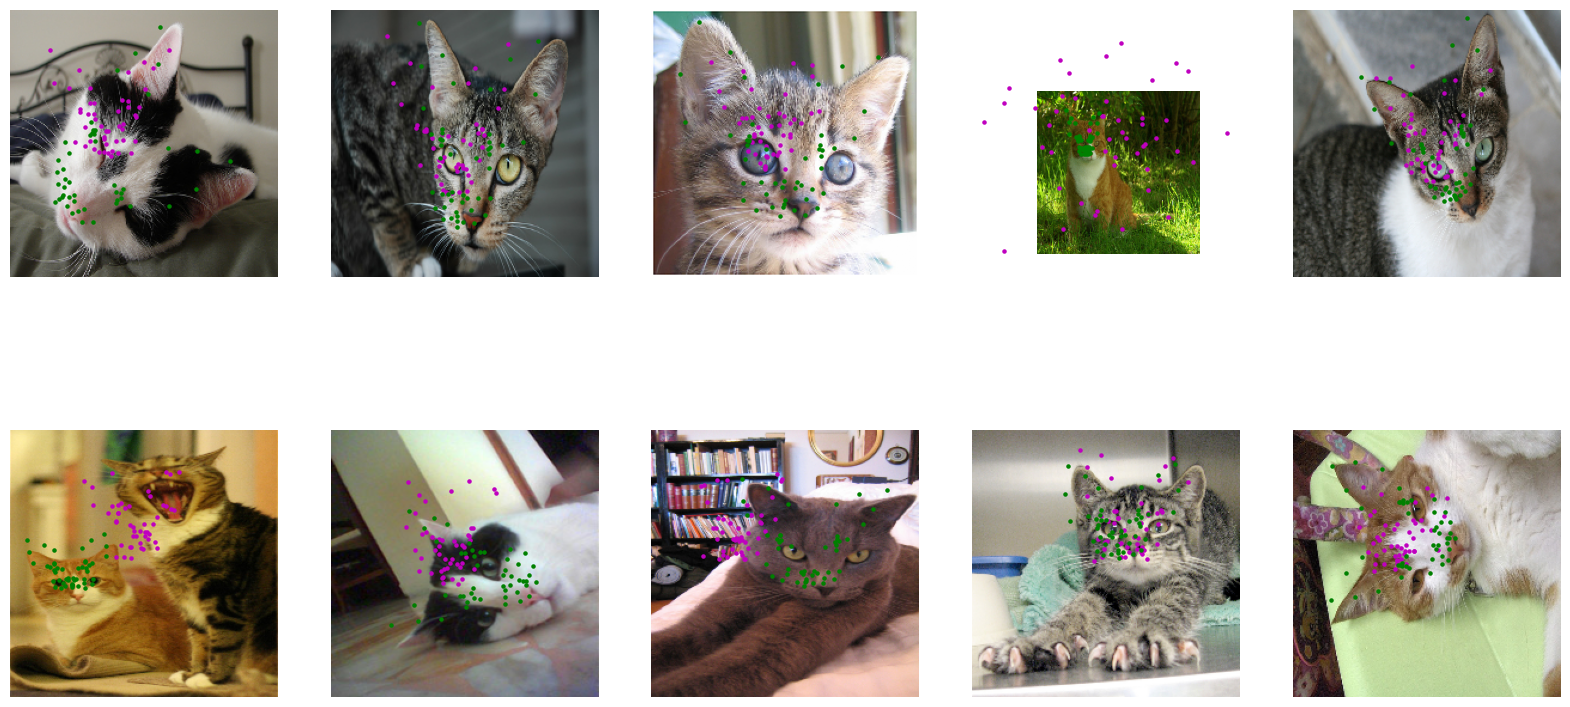

In [25]:
# 테스트 출력 시각화
visualize_output(test_images, test_outputs, gt_pts)

[[ 6.1026961e-03 -4.6554491e-02 -8.2457595e-02 -1.3621536e-01]
 [ 7.0805006e-02 -4.5633860e-02  8.4566295e-02 -4.2825006e-05]
 [ 1.8724671e-02 -1.1877503e-01 -2.0282888e-03  5.3278469e-02]
 [ 7.2059125e-02 -1.4869818e-01  9.8542631e-02  1.3759771e-01]]
(4, 4)


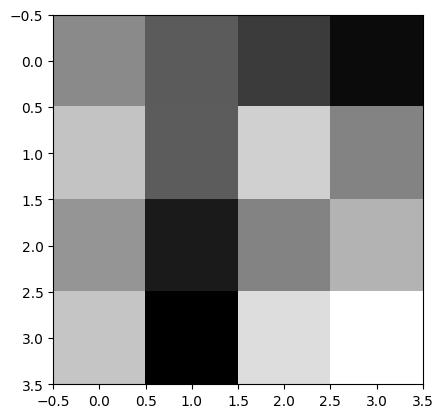

In [26]:
# 첫 번째 conv 레이어의 필터 가중치 시각화
weights1 = net.conv1.weight.data.cpu()
w = weights1.numpy()
filter_index = 0
print(w[filter_index][0])
print(w[filter_index][0].shape)
plt.imshow(w[filter_index][0], cmap="gray")

First convolutional layer


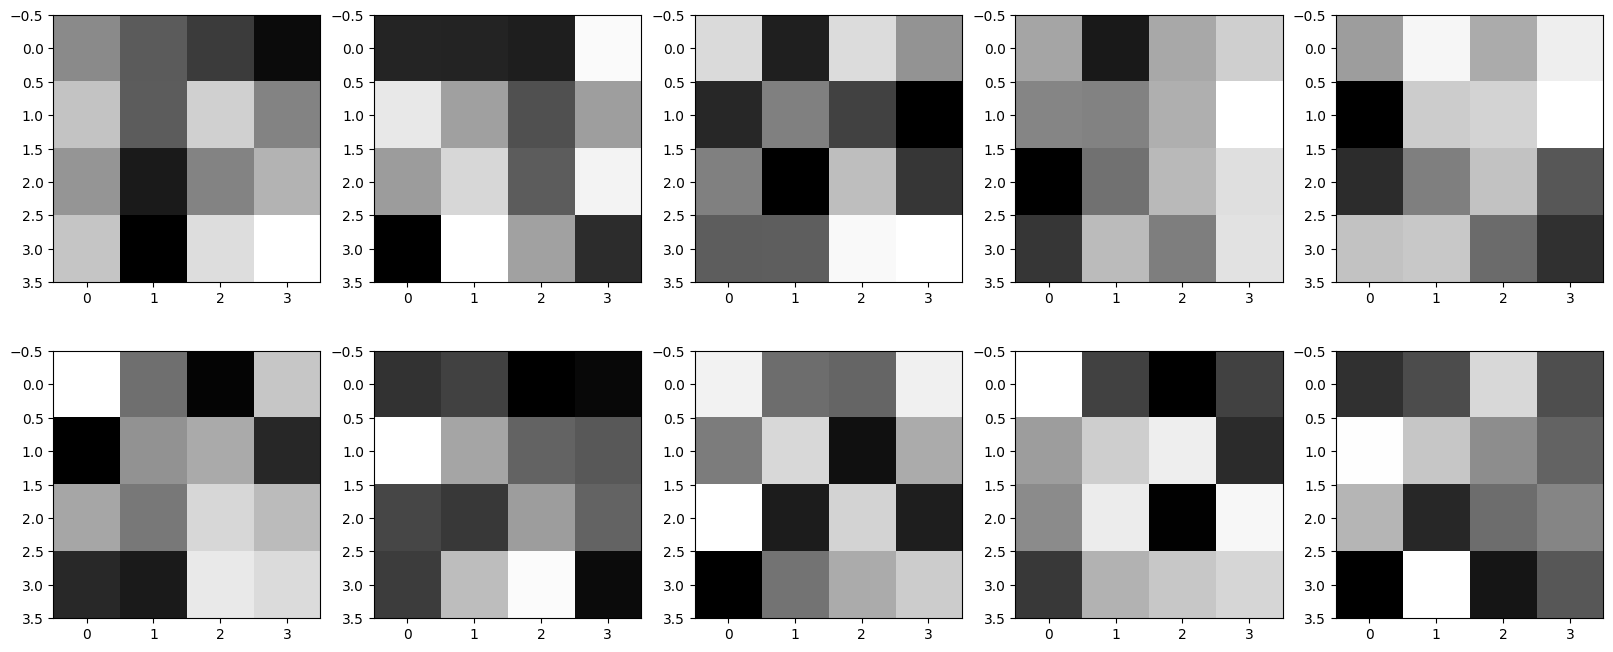

In [27]:
# 첫 번째 conv 레이어의 필터 시각화
weights = net.conv1.weight.data.cpu()
w = weights.numpy()
fig = plt.figure(figsize=(20, 8))
columns = 5
rows = 2
for i in range(0, columns * rows):
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(w[i][0], cmap="gray")
print("First convolutional layer")
plt.show()


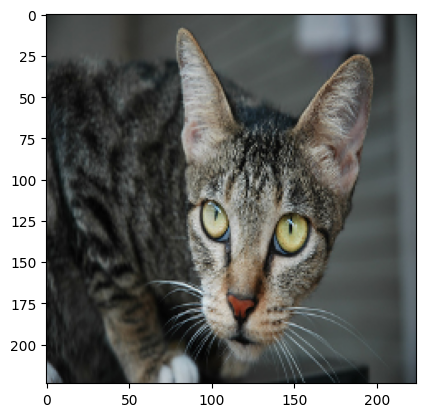

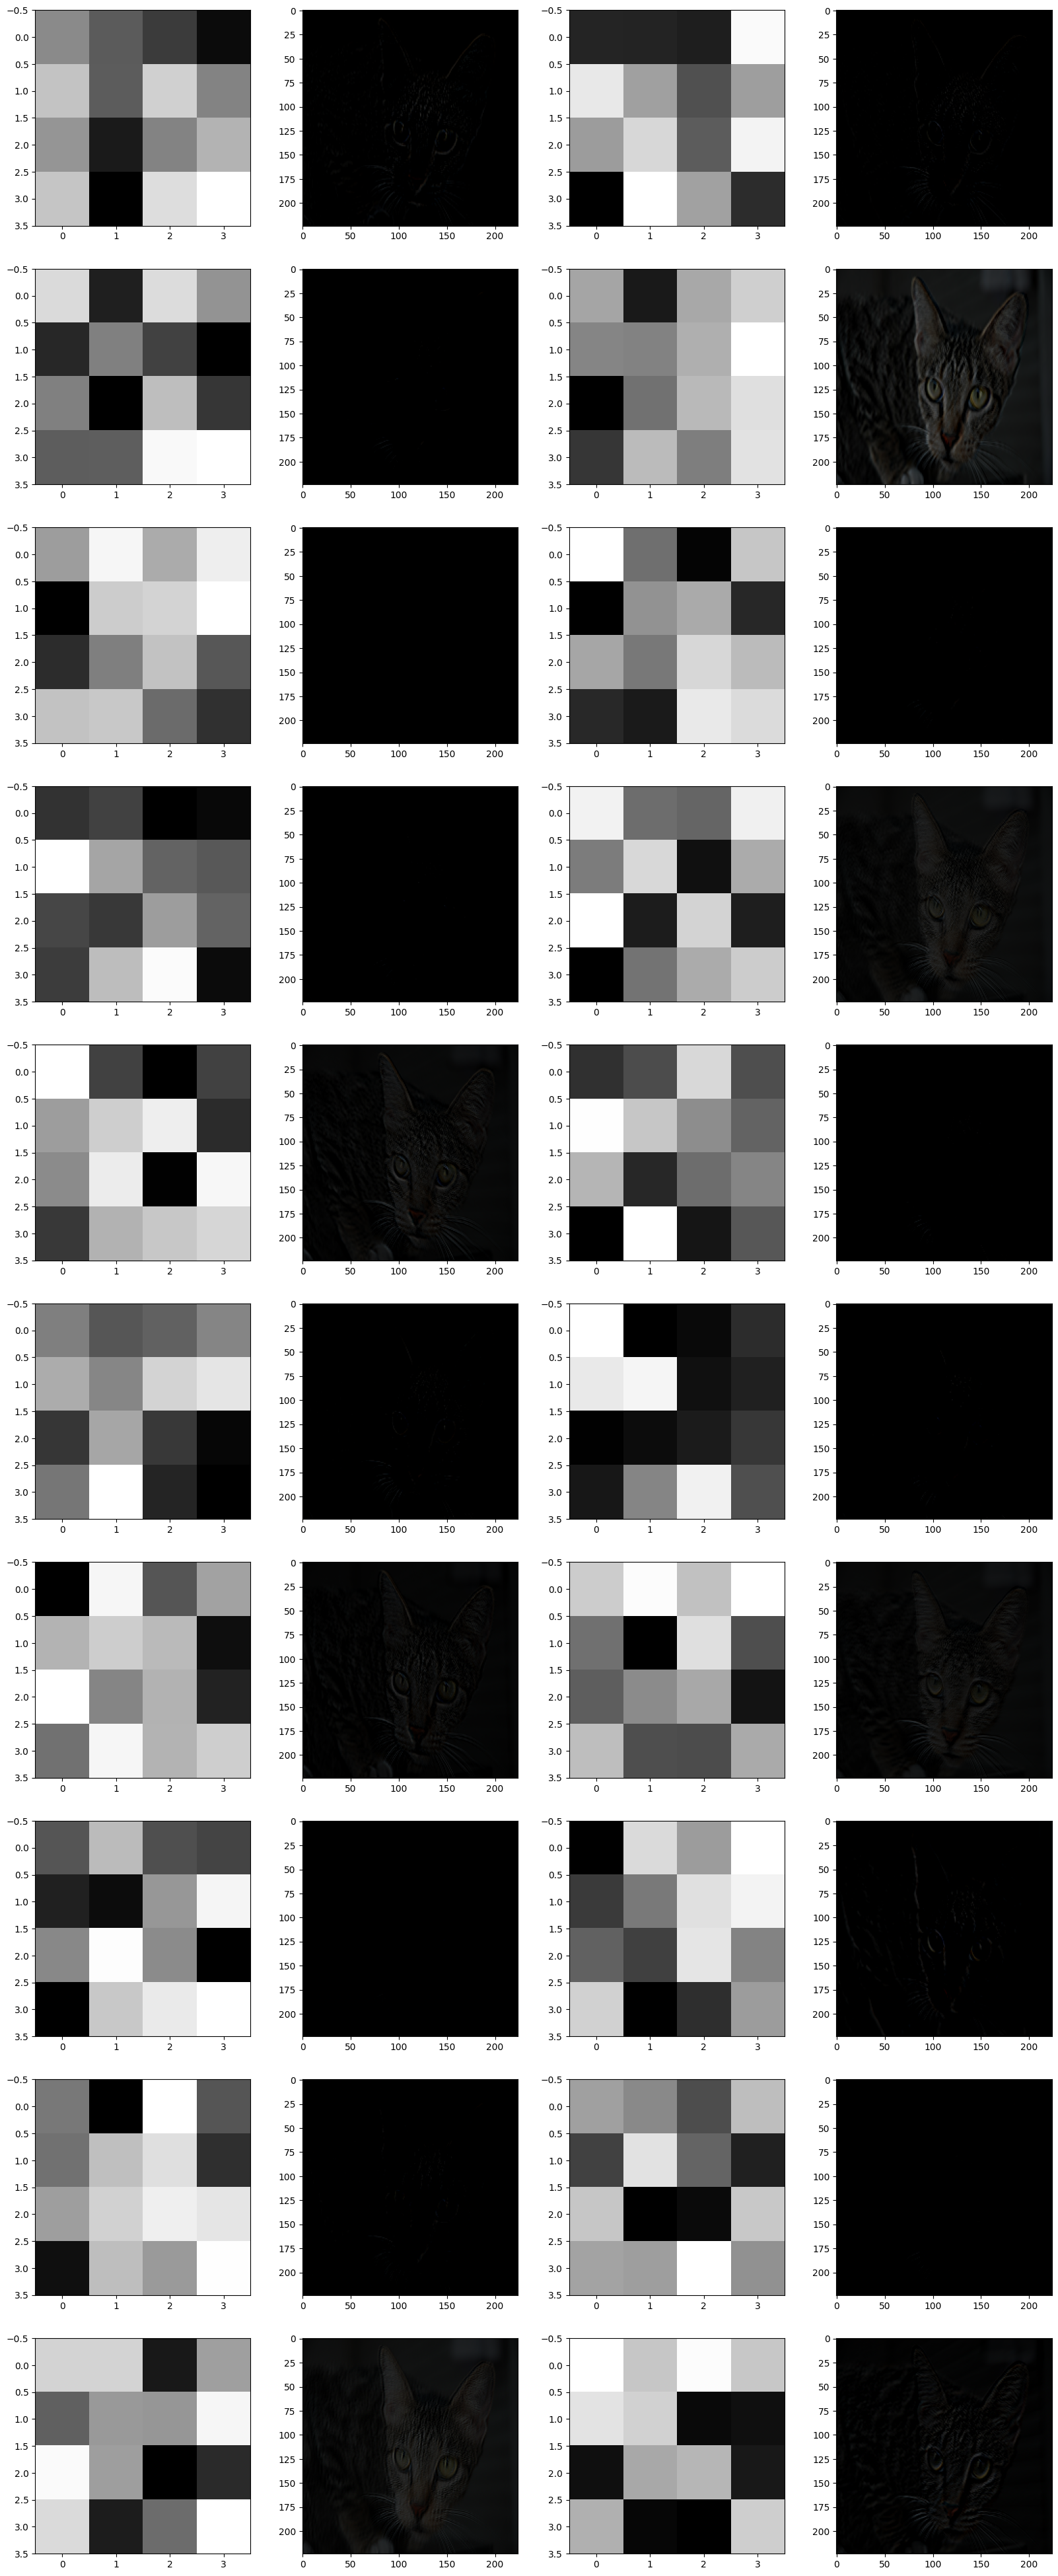

In [28]:
# 필터가 적용된 이미지 시각화
img = np.transpose(test_images[1].cpu().numpy(), (1, 2, 0))  # 형식을 (높이, 너비, 채널)로 변경
plt.imshow(img)
weights = net.conv1.weight.data.cpu()
w = weights.numpy()
fig = plt.figure(figsize=(20, 50))
columns = 4
rows = 10
for i in range(0, columns * rows):
    fig.add_subplot(rows, columns, i + 1)
    if (i % 2) == 0:
        plt.imshow(w[int(i / 2)][0], cmap="gray")
    else:
        c = cv2.filter2D(img, -1, w[int((i - 1) / 2)][0])
        plt.imshow(c, cmap="gray")
plt.show()


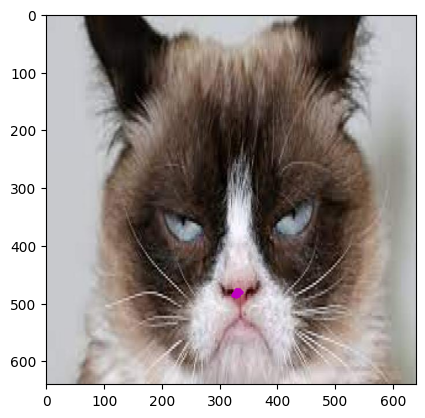

In [29]:
# 얼굴 영역 기반 키포인트 탐지 및 시각화
test_image = cv2.imread('/home/work/XAI/BITAmin/Cat Emotions.v1-test.folder/train/Angry/4_a_jpeg.rf.96a9cd63e89cf74186265ff769d7966e.jpg')
test_image_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

keypoints = process_image_and_detect_keypoints(test_image_rgb, net)

if keypoints is not None:
    show_all_keypoints(test_image_rgb, keypoints)
else:
    print("No face detected in the image.")